# **This file is to run code to produce various plots for the Summer 2025 SULI appointment**
#### *Coded by Brandon Swanson<br>Mentored by Bhupendra Raut*

#### Imports & Helpers

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
import squarify, math
from matplotlib.patches import Rectangle

# — PARAMETERS — 
# Change these at the top as needed for new data:
n = 5    # number of clusters

nid = 4    # cluster ID to export dates for

# — DATA LOADING / CLEANING — 
def load_and_clean_with_time(ds_path, variables, time_dim='time'):
    ds     = xr.open_dataset(ds_path, engine='netcdf4')
    arrays = [ds[v].to_numpy().ravel() for v in variables]
    times  = ds[time_dim].to_numpy().ravel()
    mask   = np.all([~np.isnan(a) for a in arrays], axis=0)
    data   = np.column_stack([a[mask] for a in arrays])
    times  = times[mask]
    df     = pd.DataFrame(data, columns=variables)
    df['time'] = pd.to_datetime(times)
    return df

# — CLUSTERING — 
def cluster_and_attach(df, variables, n_clusters):
    X      = df[variables].values
    scaler = StandardScaler()
    Xs     = scaler.fit_transform(X)
    km     = KMeans(n_clusters=n_clusters, random_state=42).fit(Xs)
    df['cluster'] = km.labels_ + 1
    return df, km

# — PLOTTING HELPERS — 
def plot_cluster_histogram(df, n_clusters):
    counts = df['cluster'].value_counts().sort_index()
    plt.figure()
    plt.bar(counts.index, counts.values)
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.title('Cluster Size Distribution')
    plt.xticks(range(1, n_clusters+1))
    plt.tight_layout(); plt.show()

def plot_all_variable_histograms(df):
    for var in df.columns:
        if var == 'cluster': continue
        plt.figure()
        df[var].hist(bins=50, edgecolor='black')
        plt.title(f'Histogram of {var}')
        plt.xlabel(var); plt.ylabel('Frequency')
        plt.tight_layout(); plt.show()

def plot_variable_pairs(df, n_clusters):
    sns.pairplot(df, hue='cluster',
                 hue_order=range(1, n_clusters+1),
                 palette='tab10', corner=False)
    plt.show()

def plot_box_time(df, variables):
    df['hour'] = df.index.hour
    clusters = sorted(df['cluster'].unique())
    for var in variables:
        if var == 'cluster': continue
        data = [df.loc[df['cluster']==c, var].values for c in clusters]
        plt.figure()
        plt.boxplot(data, tick_labels=clusters, showfliers=False)
        plt.title(f'{var.capitalize()} by Cluster')
        plt.xlabel('Cluster'); plt.ylabel(var)
        plt.tight_layout(); plt.show()

def mosaic_plot(df, cat1, cat2, title=None):
    data = df.groupby([cat1,cat2]).size().to_dict()
    plt.figure(figsize=(8,6))
    mosaic(data, title=title or f"{cat1} vs {cat2}",
           labelizer=lambda k: str(k[1]))
    plt.xlabel(cat1); plt.ylabel(cat2)
    plt.tight_layout(); plt.show()

def variable_importance_bss(df, variables, n_clusters):
    X      = df[variables].values
    scaler = StandardScaler()
    Xs     = scaler.fit_transform(X)
    km     = KMeans(n_clusters=n_clusters, random_state=42).fit(Xs)
    c, labels = km.cluster_centers_, km.labels_
    counts = np.bincount(labels, minlength=n_clusters)
    bss = np.sum(c**2 * counts[:,None], axis=0)
    return pd.Series(bss, index=variables).sort_values(ascending=False)

def plot_per_cluster_treemaps(km, variables, n_clusters):
    # pick a colormap and grab len(variables) distinct colors
    cmap   = plt.get_cmap('tab20')
    colors = [cmap(i/len(variables)) for i in range(len(variables))]
    
    for cid in range(1, n_clusters+1):
        center = km.cluster_centers_[cid-1]
        sizes  = np.abs(center)
        labels = [f"{v}\n{center[i]:+.2f}" 
                  for i, v in enumerate(variables)]
        
        plt.figure(figsize=(5,5))
        squarify.plot(
            sizes=sizes,
            label=labels,
            color=colors,
            pad=True,
            bar_kwargs={'linewidth':1,'edgecolor':'white'}
        )
        plt.title(f"Cluster {cid}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

def export_cluster_dates(df, cluster_id, filename):
    dates = df.index[df['cluster']==cluster_id]
    with open(filename, 'w') as f:
        for dt in dates:
            f.write(dt.strftime('%Y-%m-%d %H:%M:%S')+"\n")
    print(f"Saved {len(dates)} timestamps to {filename}")

#### Load & Clean

In [3]:
vars_list = ['pm2.5','pm1.0','pm10.0','co','no','o3','no2','temperature','dewpoint','u_wind','v_wind']

df = load_and_clean_with_time('D://Data//crocus_neiu_a1_and_filtered_30min.nc', vars_list)

C:\Users\video\.conda\envs\my_project\Lib\site-packages\xarray\backends\plugins.py:110: RuntimeWarning: Engine 'gini' loading failed:
`np.round_` was removed in the NumPy 2.0 release. Use `np.round` instead.
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)


#### Cluster & Attach

In [4]:
df, km = cluster_and_attach(df, vars_list, n_clusters=n)

# Make 'time' the index and extract hour
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['hour'] = df.index.hour

print(df.head())
print(df['cluster'].value_counts().sort_index())

                         pm2.5      pm1.0     pm10.0        co        no  \
time                                                                       
2023-05-20 00:00:00  28.350000  24.050000  35.450000  0.218233  0.012033   
2023-05-20 00:30:00  22.733333  19.316667  28.150000  0.179633  0.012567   
2023-05-20 01:00:00  23.266667  19.966667  28.416667  0.173333  0.013800   
2023-05-20 01:30:00  20.916667  17.783333  25.566667  0.179433  0.016300   
2023-05-20 02:00:00  19.633333  16.633333  23.583333  0.185333  0.017000   

                           o3       no2  temperature  dewpoint    u_wind  \
time                                                                       
2023-05-20 00:00:00  0.027467  0.013567    15.220000  7.995897 -1.607238   
2023-05-20 00:30:00  0.022667  0.009133    14.220000  6.396147 -1.808306   
2023-05-20 01:00:00  0.020900  0.010767    13.826667  6.456700 -2.156636   
2023-05-20 01:30:00  0.022067  0.010200    13.553333  6.554624 -1.531059   
2023-05-20 

#### Cluster Histogram

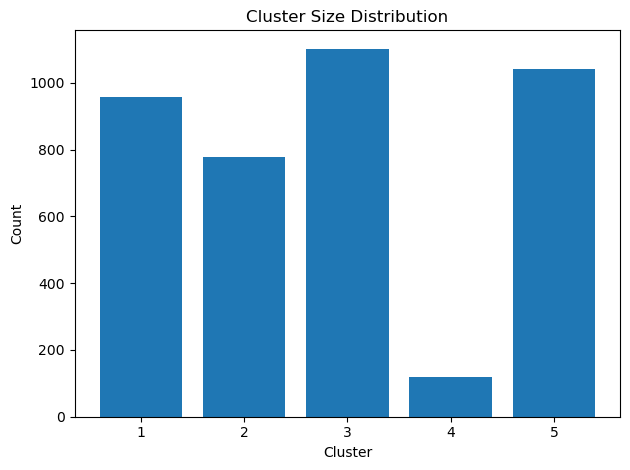

In [5]:
plot_cluster_histogram(df, n_clusters=n)

#### Variable Histograms

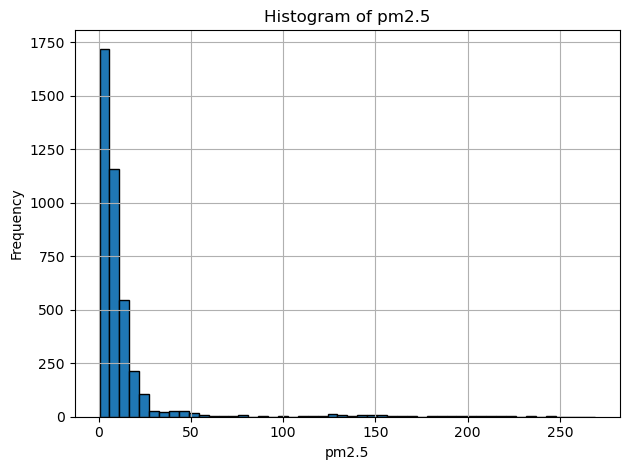

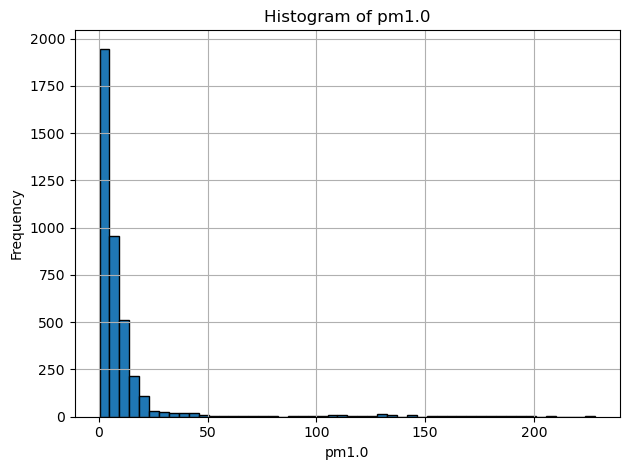

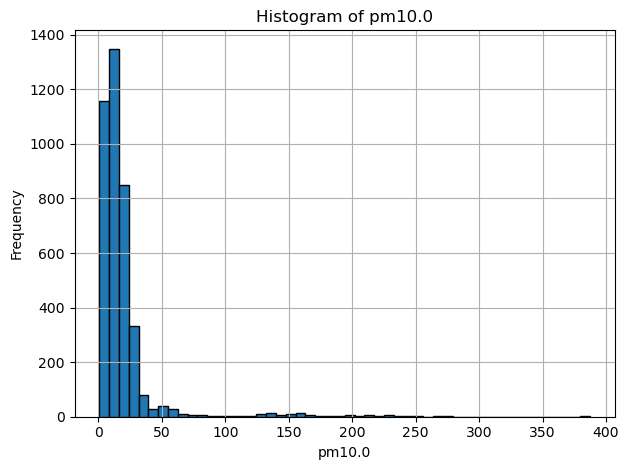

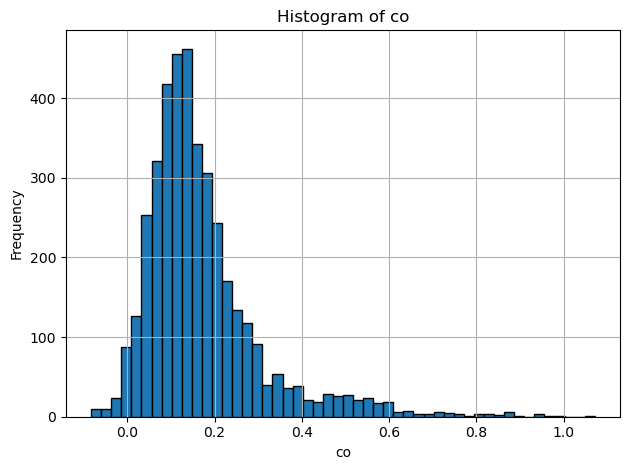

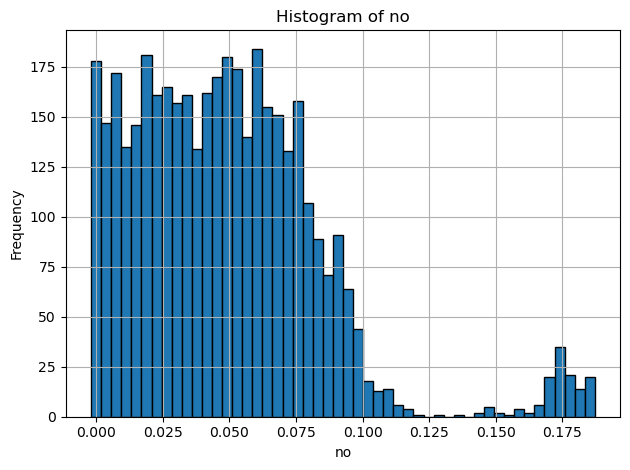

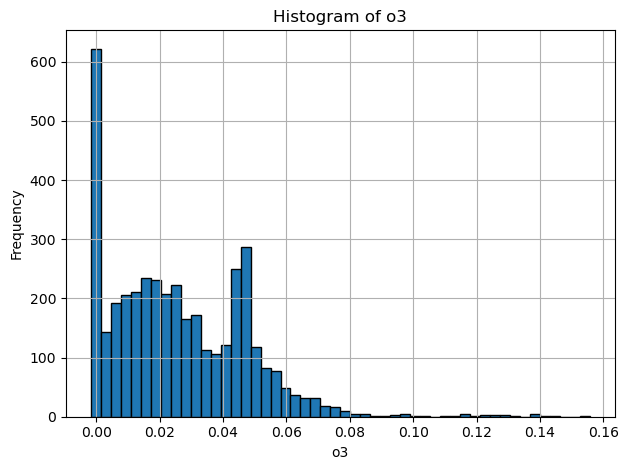

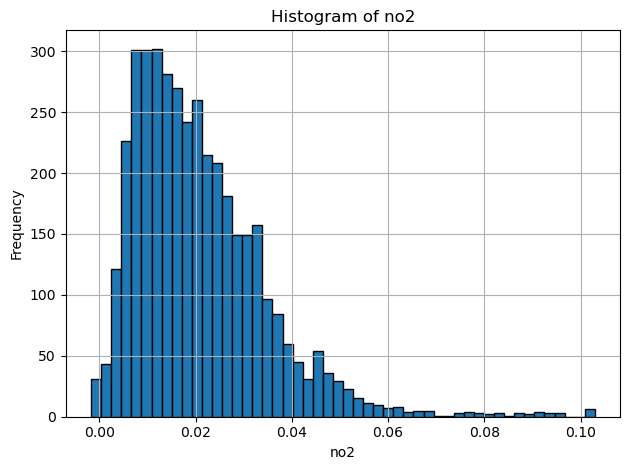

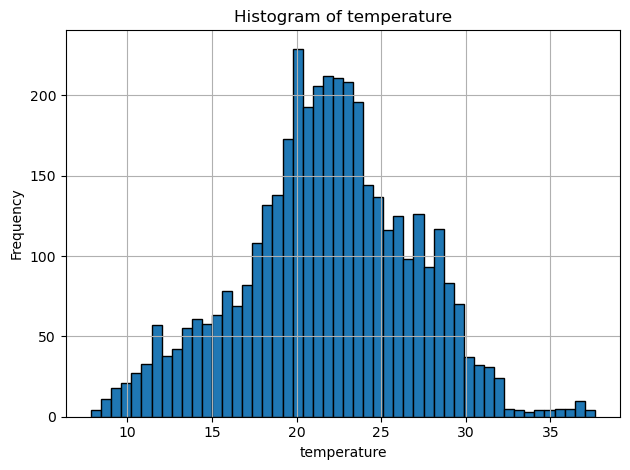

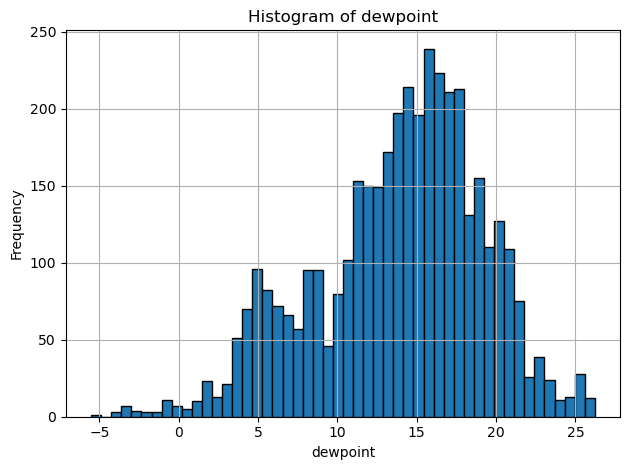

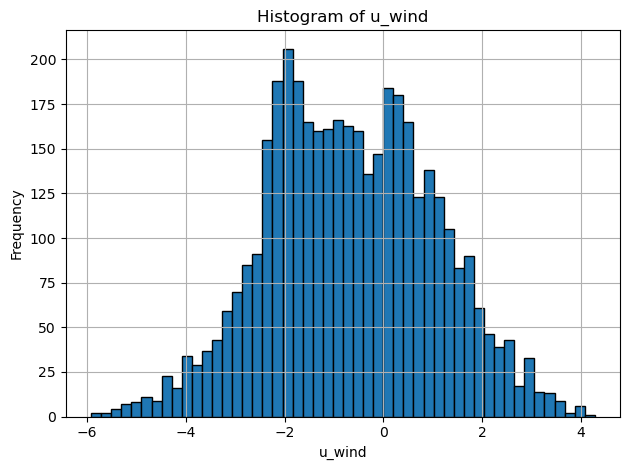

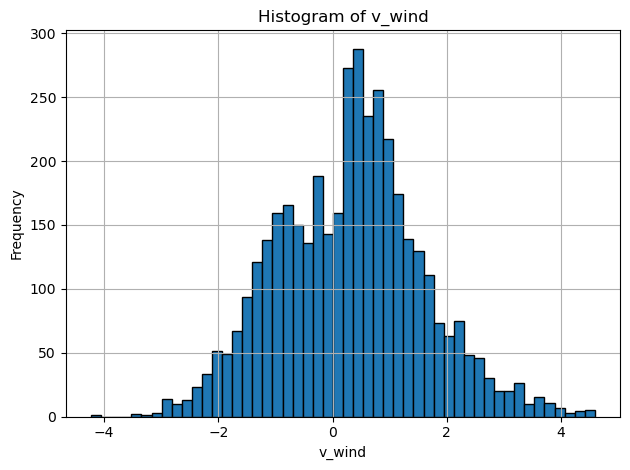

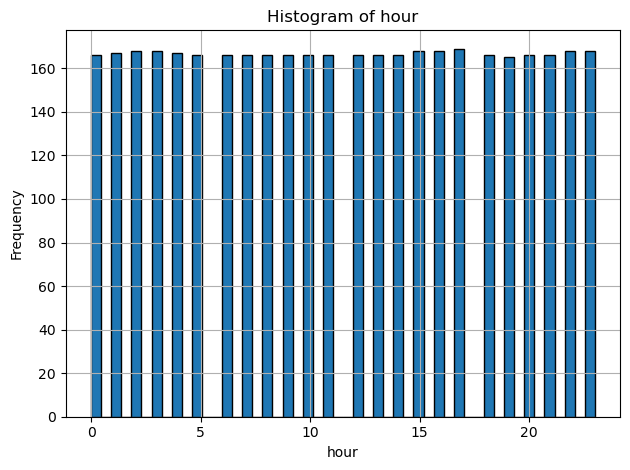

In [6]:
plot_all_variable_histograms(df)

#### Boxplots by Cluster

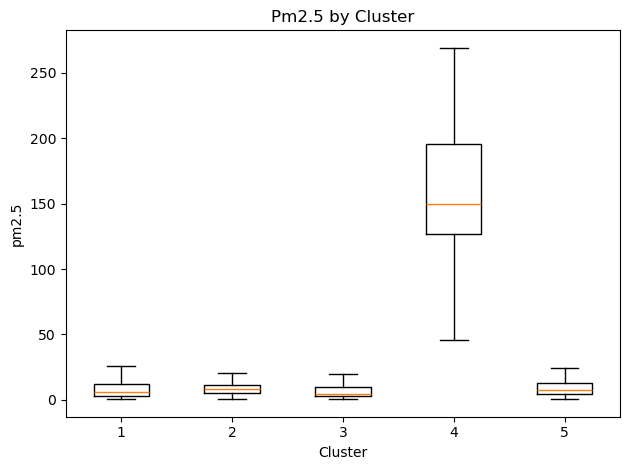

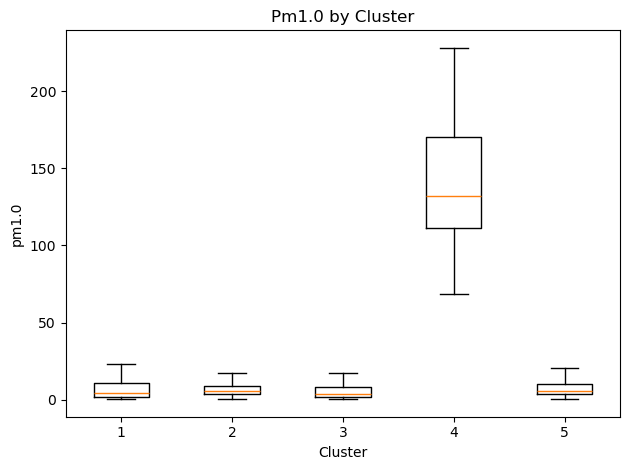

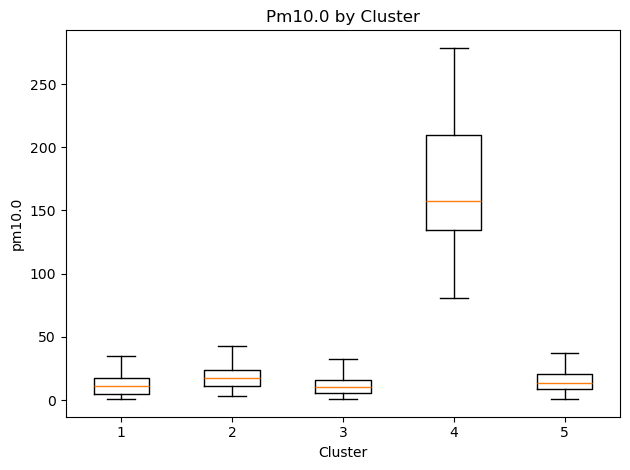

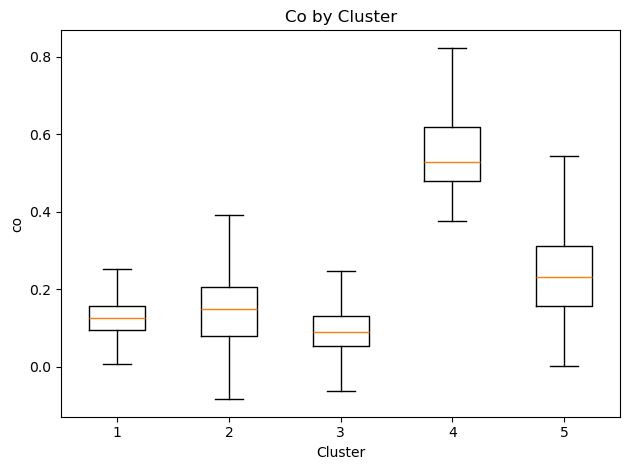

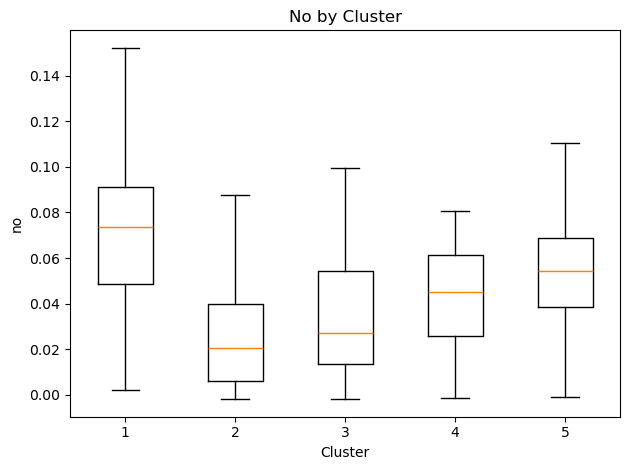

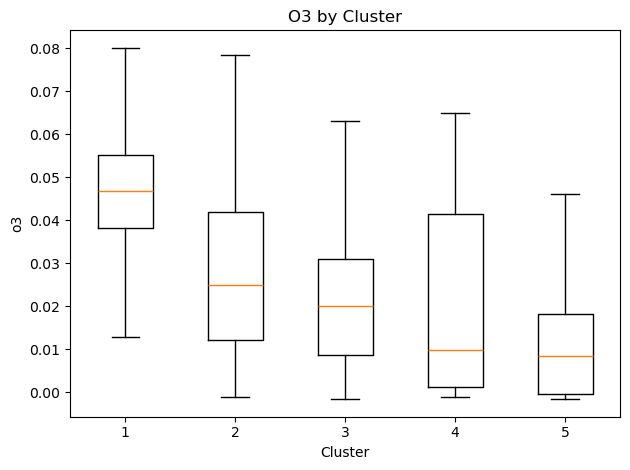

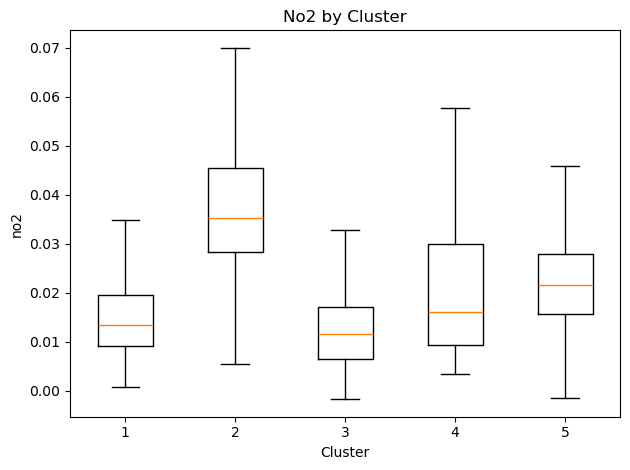

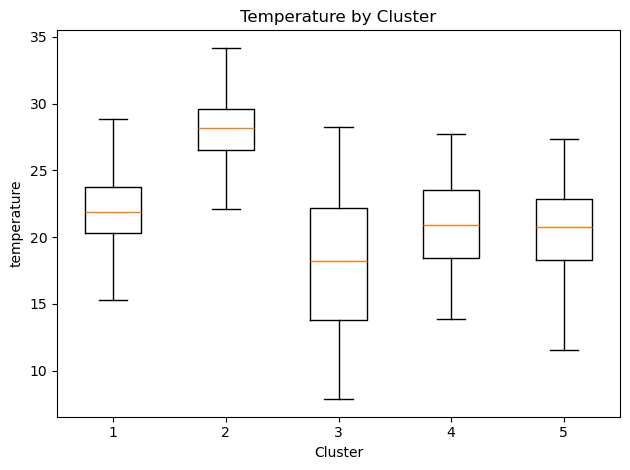

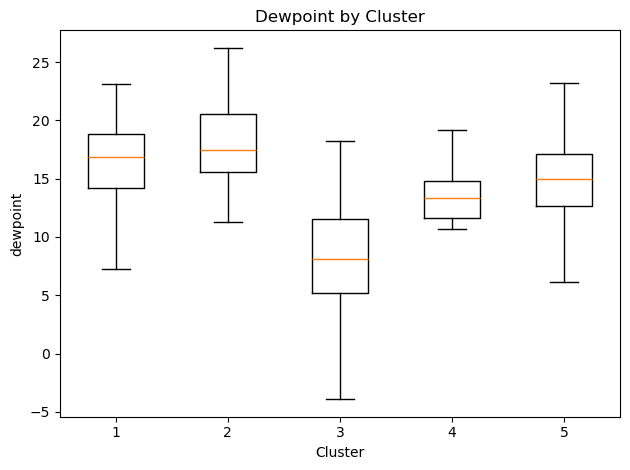

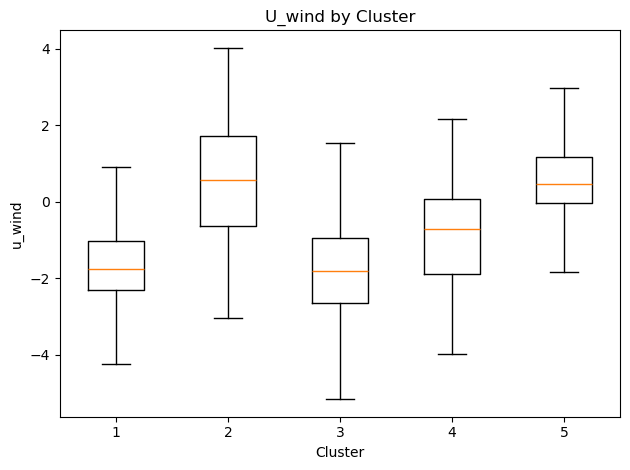

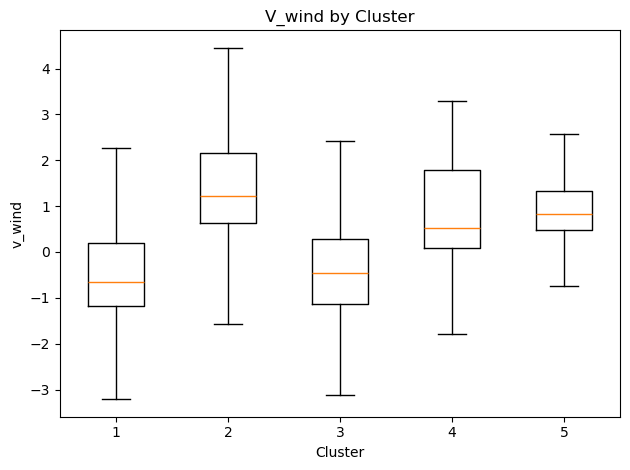

In [11]:
plot_box_time(df, vars_list)

#### Pairplot

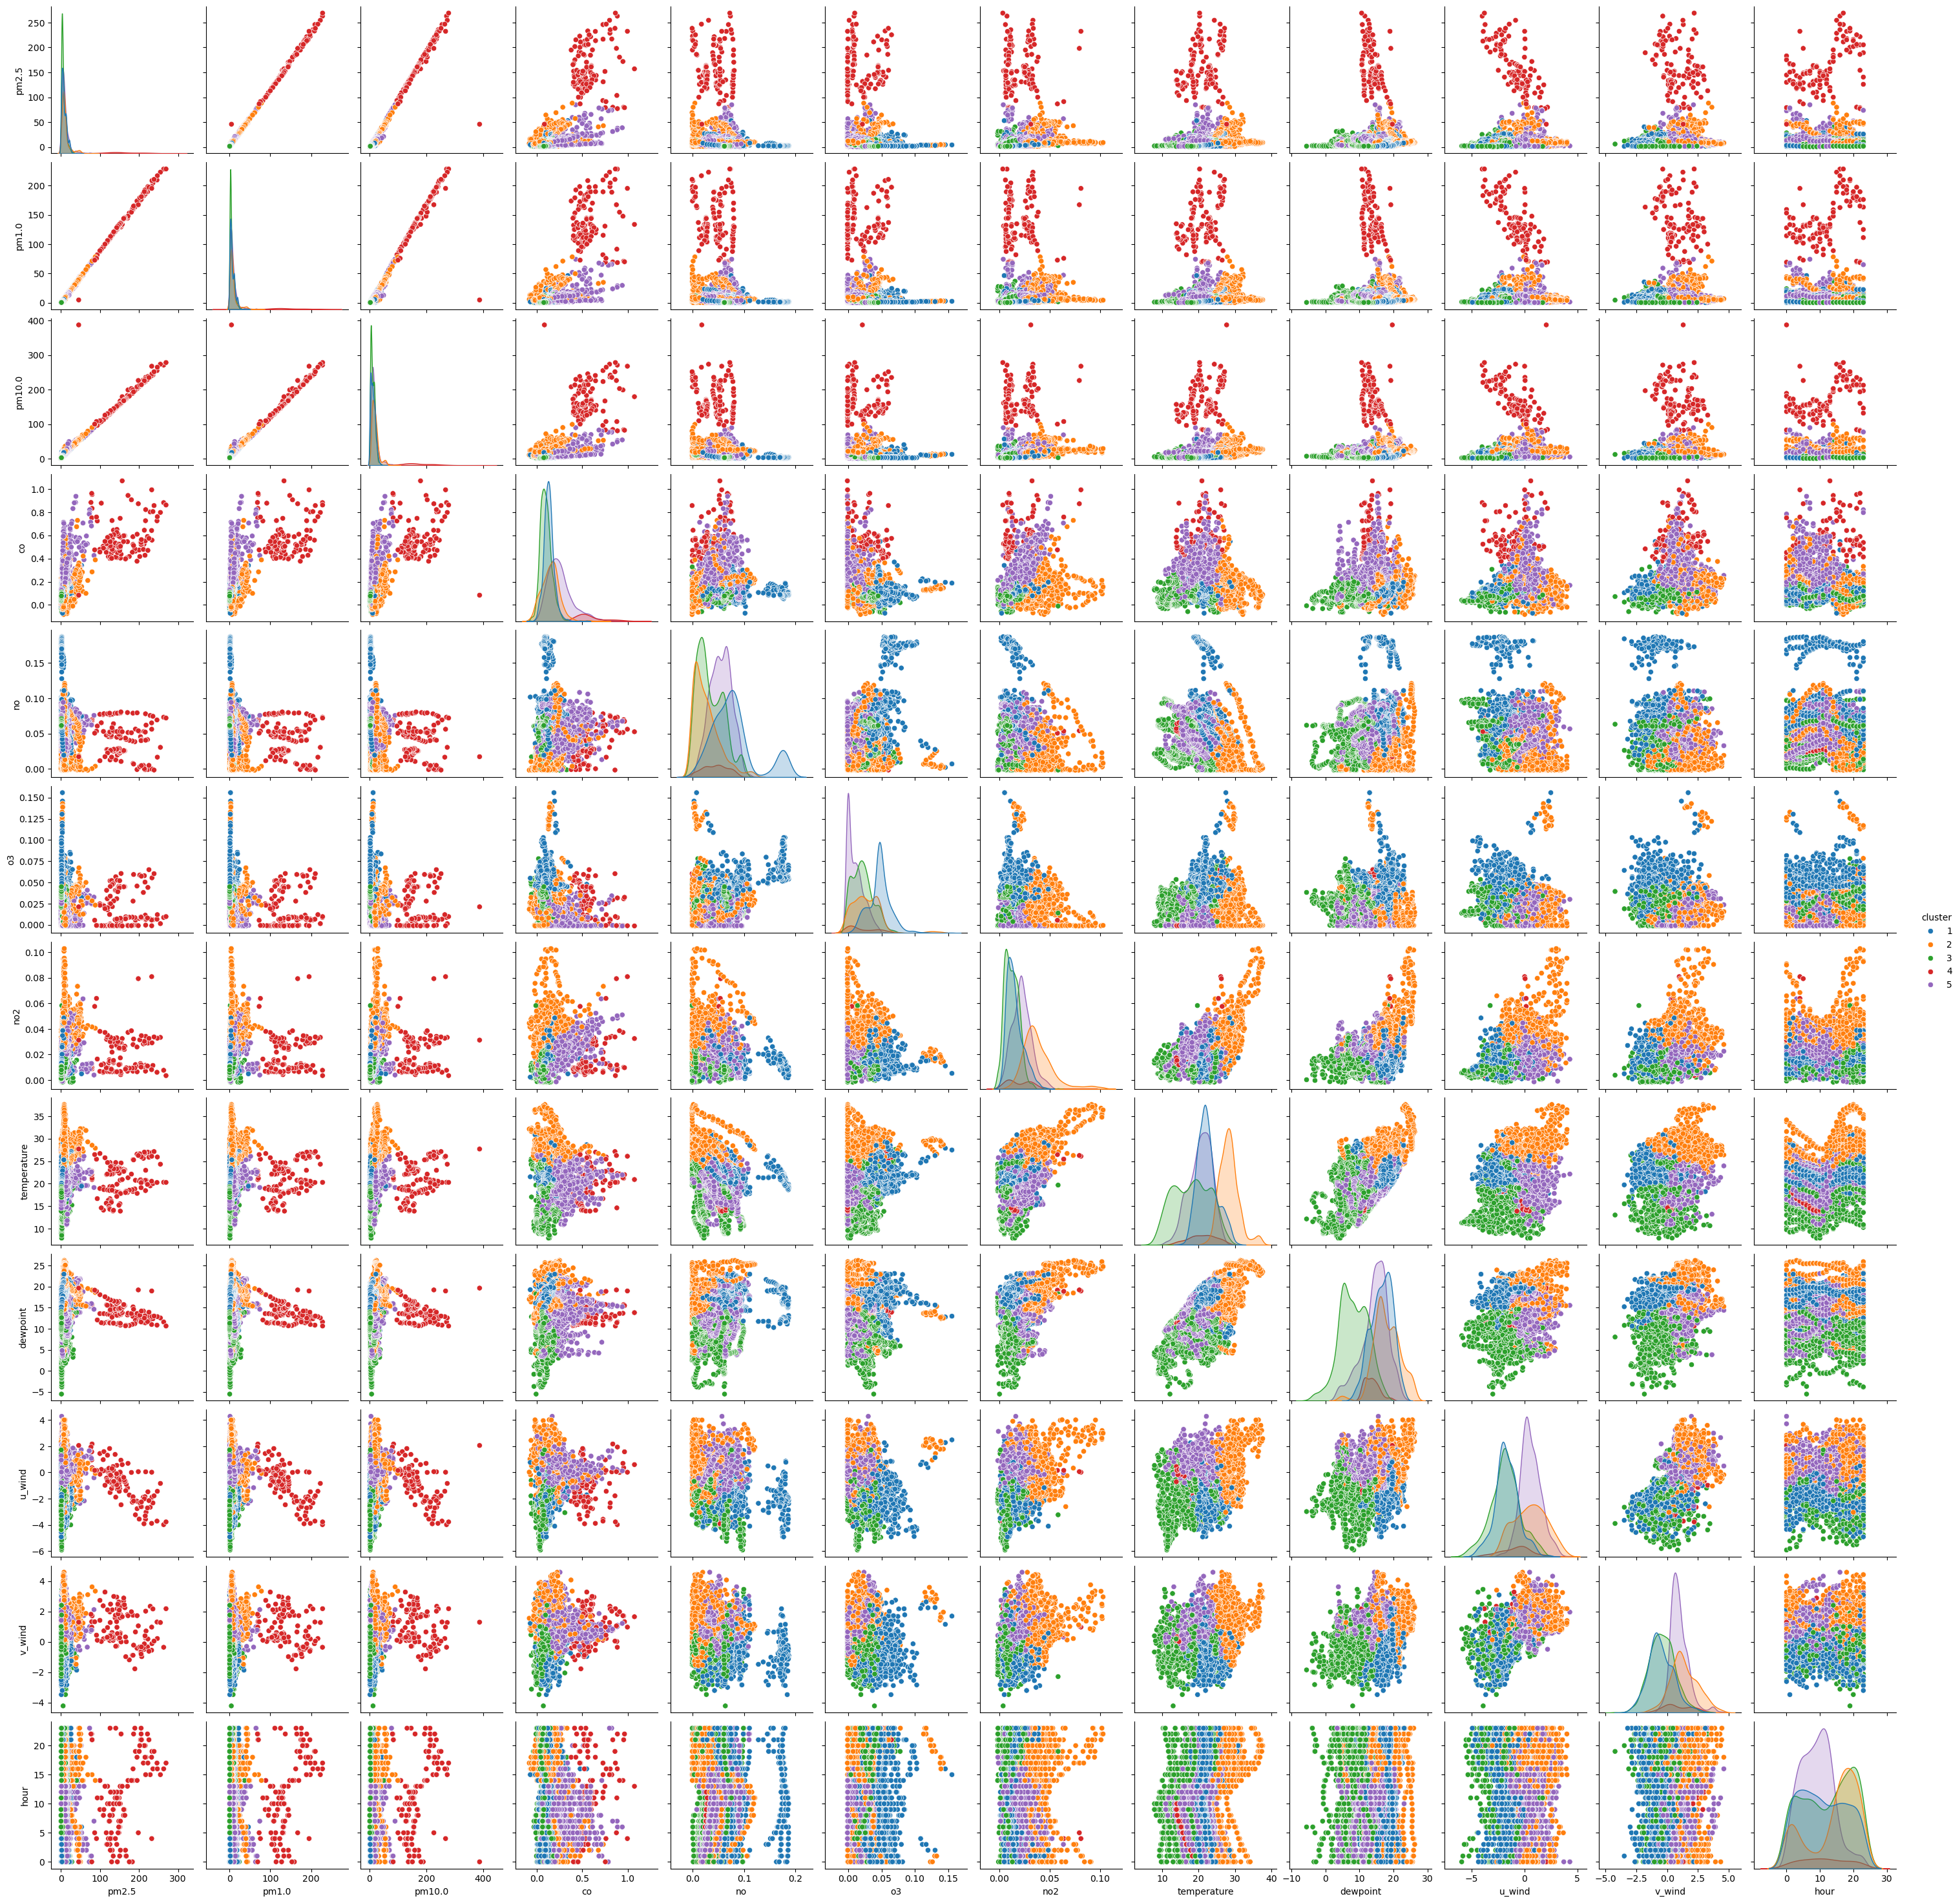

In [12]:
plot_variable_pairs(df, n_clusters=n)

#### Mosaic Plot (Hour vs. Cluster)

<Figure size 800x600 with 0 Axes>

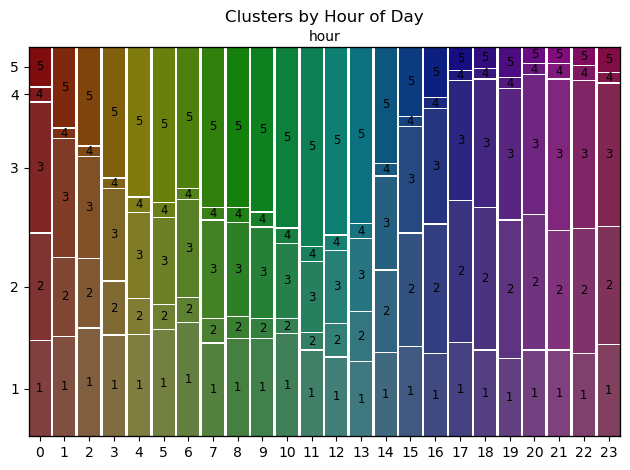

In [13]:
mosaic_plot(df, 'hour', 'cluster', title="Clusters by Hour of Day")

#### Variable Importance Bar Chart

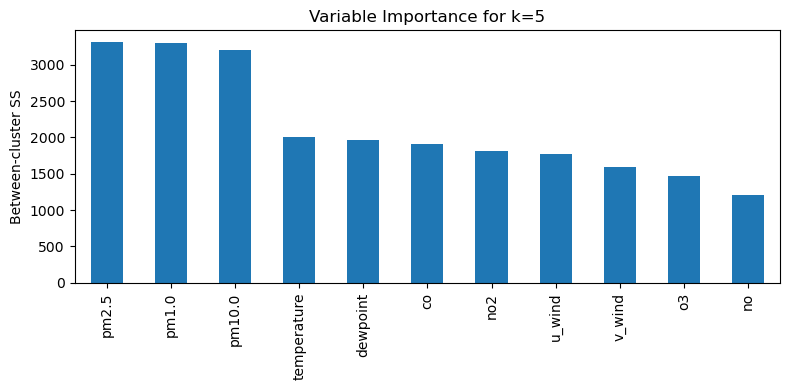

In [22]:
imp = variable_importance_bss(df, vars_list, n_clusters=n)

plt.figure(figsize=(8,4))
imp.plot(kind='bar')
plt.ylabel('Between-cluster SS')
plt.title(f'Variable Importance for k={n}')
plt.tight_layout()
plt.show()

#### Per‐Cluster Treemaps

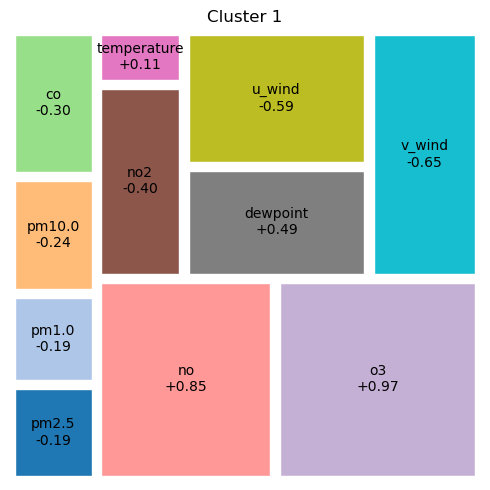

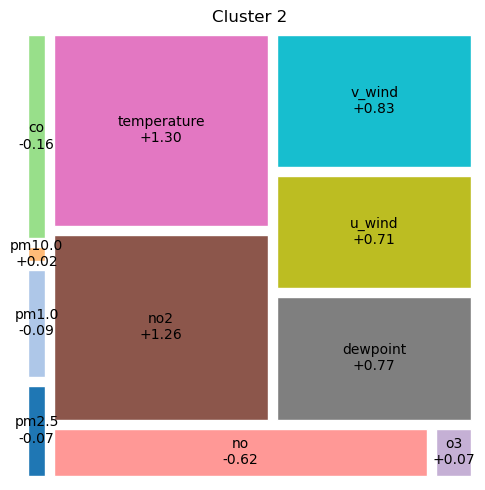

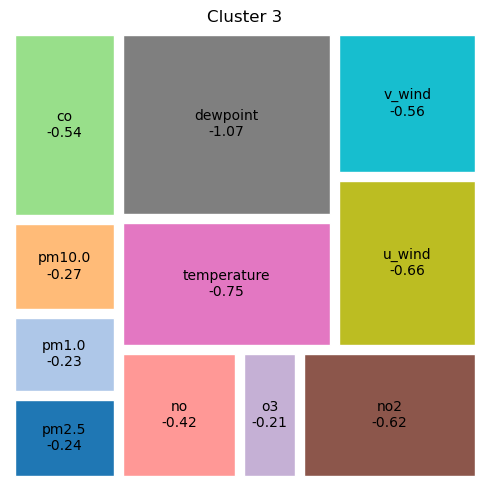

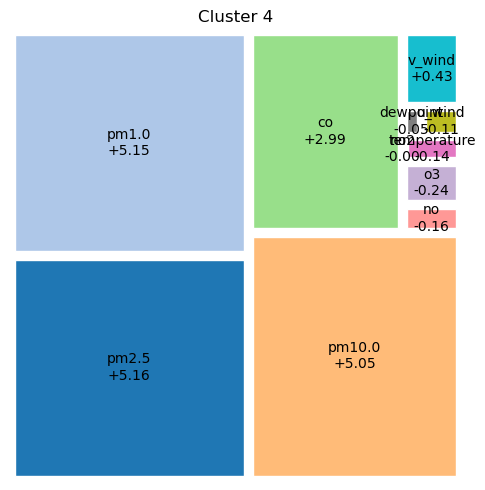

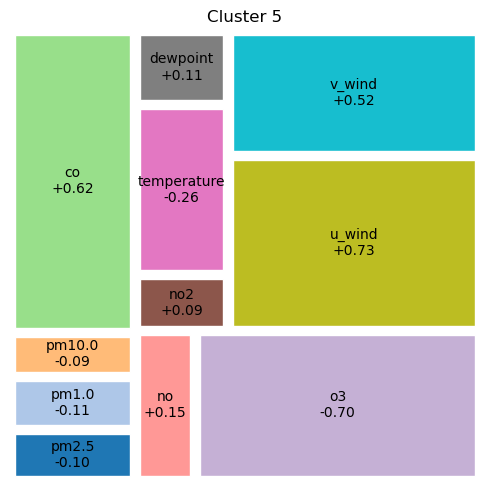

In [18]:
plot_per_cluster_treemaps(km, vars_list, n_clusters=n)

#### Overall Treemap (BSS)

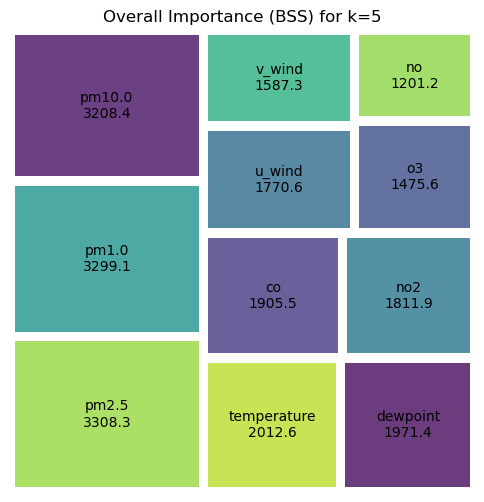

In [19]:
sizes  = imp.values
labels = [f"{v}\n{imp[v]:.1f}" for v in imp.index]

plt.figure(figsize=(6,6))
squarify.plot(sizes=sizes, label=labels, alpha=0.8, pad=True)
plt.title(f'Overall Importance (BSS) for k={n}')
plt.axis('off')
plt.show()

#### Export Cluster Dates

In [ ]:
export_cluster_dates(df, cluster_id=nid, filename=f'cluster{nid}_dates.txt')

#### Cluster 4 experimentation

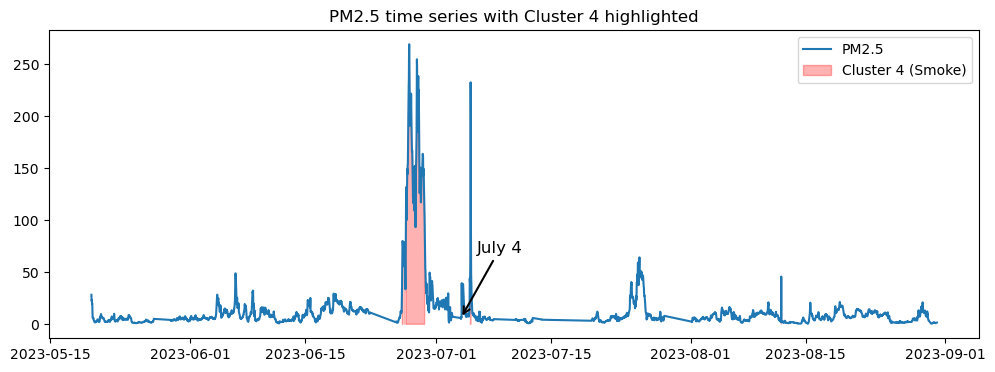

In [30]:
plt.figure(figsize=(12,4))
plt.plot(df.index, df['pm2.5'], label='PM2.5')
mask4 = df['cluster']==4
plt.fill_between(df.index, df['pm2.5'], where=mask4,
                 color='red', alpha=0.3, label='Cluster 4 (Smoke)')
# annotate July 4
july4 = pd.Timestamp('2023-07-04')
# pick the PM2.5 value at or just before midnight on July 4
pm25_july4 = df['pm2.5'].asof(july4)

plt.annotate(
    'July 4',
    xy=(july4, pm25_july4),
    xytext=(july4 + pd.Timedelta(days=2), pm25_july4 + 60),
    arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
    fontsize=12,
    va='bottom'
)
plt.legend(); plt.title('PM2.5 time series with Cluster 4 highlighted')
plt.show()